## Imports

In [106]:
import pandas as pd
import nltk, re, string
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from nltk.corpus import stopwords

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale


from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

import glove #Installing glove on mac seemed non-trivial. Running it on Linux, pickling results for further use.
import pickle 

#Let's try some visualizations
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Preprocess Data

Read the csv file and make a dataframe.
- For training: Randomize and Divide it into 80:20 partitions

In [3]:
def load_Dataset(run="train"):
    df = pd.read_csv("train.csv")
    df = df[df["Comment"].notnull()]
    df.apply(np.random.permutation)
    if run=="train":
        df_train = df[:round(0.8*len(df))]
        df_test = df[round(0.8*len(df)):]
    elif run=="test":
        df_train = df
        df_test = pd.read_csv("test_with_solutions.csv")
#         df_test = pd.read_csv("impermium_verification_labels.csv")
    return df_train, df_test

### Tokenization

This function takes a text and does the following to return the tokens:
* Use nltk's TweetTokenizer to get tokens
* Use wordNetLemmatizer for lemmatization
* Use porterStemmer to stem the resulting tokens

In [101]:
def build_tokens(text):
    tweetTokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tweetTokenizer.tokenize(text)
    tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens]
    tokens= [nltk.PorterStemmer().stem(token) for token in tokens]
    return tokens

## Feature Extraction

### - Word2Vec Features using Glove 

-  Loading the 27B tweet dataset 
-  Got the significant parts and pickled for later use (glove_twitter_200d.pkl) 

In [5]:
# w2v = glove.Glove.load_stanford('glove.twitter.27B.200d.txt')

In [6]:
# learned_word_vectors = w2v.word_vectors
# learned_dictionary = w2v.dictionary

# pickle.dump((learned_word_vectors,learned_dictionary),open('glove_twitter_200d.pkl','wb'))

In [7]:
learned_word_vectors,learned_dictionary = pickle.load( open( "glove_twitter_200d.pkl", "rb" ) ) 
#Unable to upload on git. Will post somewhere for download separately.   

### This Function does the following:
* To make Tweet Vector we take all tokens in a tweet and see if we have a word2vec for that word. We keep adding all these word vectors and take average to get a tweet vector
* We are making our entire tweet into a 200 dimensional vector

In [18]:
# t = build_tokens(df_train.Comment[0])

def make_tweetVector(df_comments):
    tweetVector = np.zeros((len(df_comments),200),dtype='float')
    count = 0 
    for text in df_comments:
        valids= 0
        tokens = build_tokens(text)
        rowVector = np.zeros(200,)
        for token in tokens:
            if token not in learned_dictionary:
                continue
            else:
                valids+=1
                vec = learned_word_vectors[learned_dictionary[token.lower()]]
                rowVector = np.add(rowVector,vec)
        tweetVector[count] = rowVector/valids
        count+=1
    return tweetVector

### This function does the following:
* 1. We take our tfidf and word vectors and append them to get the final vector. Since these are of different scale, we are normalising the final vector

In [67]:
# tfidf feature extraction and chi2 selection
def feature_extraction(df_train, df_test):
    vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,4), 
#                                  max_df= 0.5, 
                                 analyzer= "word",
                                 tokenizer= build_tokens ,
#                                  min_df=10,
                                 max_features=10000) #current best for max_features = 4000   
#     count_vectorizer = CountVectorizer(analyzer="word", tokenizer=build_tokens, ngram_range=(1,3), max_features=1000)
    
    X_train_tfidf = vectorizer.fit_transform(df_train["Comment"]).todense()
    X_test_tfidf = vectorizer.transform(df_test["Comment"]).todense()

    X_train_wordVec = make_tweetVector(df_train["Comment"])
    X_test_wordVec = make_tweetVector(df_test["Comment"])
    
    X_train = scale(np.hstack((X_train_tfidf,X_train_wordVec)))
    X_test = scale(np.hstack((X_test_tfidf,X_test_wordVec)))
#     X_train = X_train_tfidf
#     X_test = X_test_tfidf
    
#     X_train = scale(X_train_wordVec)
#     X_test = scale(X_test_wordVec)
    
#     ch2 = SelectKBest(chi2, k = 'all') #current best for k=2300(0.8815625)
#     X_train = ch2.fit_transform(X_train, df_train.Comment)
#     X_test = ch2.transform(X_test)
    
    ####### Debug run #######
    # feature_names = vectorizer.get_feature_names()
    # feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
    
    return X_train, X_test

## Classifier

In [116]:
# 
def classify_train(clf_type, X_train, train_category):
    if clf_type == "logreg": #81.1
#         logreg = linear_model.LogisticRegression(tol=1e-8, max_iter=8000)
        logreg = linear_model.LogisticRegression(C=8.25, max_iter=3000, tol=1e-8)
        logreg.fit(X_train, train_category)
        return logreg
    
    elif clf_type == "svm_rbf": #80.3
        clf = svm.SVC(kernel='rbf', gamma=0.0001, C=1, decision_function_shape="ovr", probability=True)
        clf.fit(X_train, train_category)
        return clf
    
    elif clf_type == "svm_linear":
        clf = svm.SVC(kernel = 'linear', probability = True)
        clf.fit(X_train, train_category)
        return clf
    
    elif clf_type == "sgd": #76.9
        clf = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet', n_jobs=-1)
        clf.fit(X_train,train_category)
        return clf
    
    elif clf_type == "nb":
        clf = MultinomialNB()
        clf.fit(X_train,train_category)
        return clf
    
    elif clf_type == "nn":
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(500,150), max_iter=50000, random_state=1)
        clf.fit(X_train,train_category)
        return clf
    
    ## - ensemble of different classifiers. 
    ## - We used a soft voting measure to combine the output
    
    elif clf_type == "ensemble":
        clf1 = linear_model.LogisticRegression(C=8.25, max_iter=3000, tol=1e-8)
        clf3 = svm.SVC(kernel='rbf', gamma=0.0001, C=1, decision_function_shape="ovr",probability=True)
        clf4 = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet', n_jobs=-1)
        eclf = VotingClassifier(estimators=[('lr',clf1),('svm_rbf',clf3), ('sgd' , clf4)], voting="soft")
        eclf = eclf.fit(X_train,train_category)
        return eclf

##### This function takes a trained classifier and a set of features as input and returns the prediction of the classifier

In [117]:
def classify_predict(clf, X_test):
    predictions = clf.predict(X_test)
    return predictions

def check_val_score(predictions, true_vals):
    return metrics.accuracy_score(true_vals,predictions)

## Getting it all together

### Validation run

In [118]:
df_train, df_test = load_Dataset()
X_train, X_test = feature_extraction(df_train, df_test)

### Visualization with t-SNE

###### we get our final X_train to 2-Dimensions and plot insults as Blue

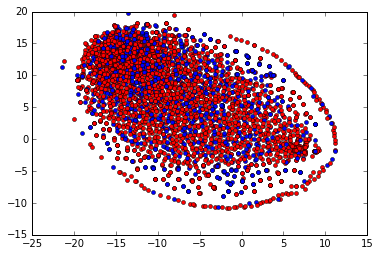

In [96]:
ts = TSNE(2)
reduced_vecs = ts.fit_transform(X_train)

#color points by word group to see if Word2Vec can separate them
for i in range(len(reduced_vecs)):
    if df_train.Insult[i] == 1:
        color = 'b'
    else:
        color = 'r'
    plt.plot(reduced_vecs[i,0], reduced_vecs[i,1], marker='o', color=color, markersize=4)

In [123]:
clf = classify_train("nn", X_train, df_train.Insult)

In [125]:
predictions = classify_predict(clf, X_test)
print(check_val_score(predictions, df_test.Insult))

0.844106463878


#### Grid Search to tune the hyper-parameters

In [108]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, df_train.Insult)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = df_test.Insult, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'kernel': 'rbf', 'gamma': 0.0001}

Grid scores on development set:

0.769 (+/-0.247) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.835 (+/-0.053) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.0001}
0.738 (+/-0.126) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
0.808 (+/-0.029) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.0001}
0.738 (+/-0.126) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}
0.797 (+/-0.053) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.0001}
0.738 (+/-0.126) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.001}
0.797 (+/-0.054) for {'C': 1000, 'kernel': 'rbf', 'gamma': 0.0001}
0.751 (+/-0.024) for {'C': 1, 'kernel': 'linear'}
0.751 (+/-0.024) for {'C': 10, 'kernel': 'linear'}
0.751 (+/-0.024) for {'C': 100, 'kernel': 'linear'}
0.751 (+/-0.024) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed o

### Final run 

In [126]:
df_train, df_test = load_Dataset("test")
X_train, X_test = feature_extraction(df_train, df_test)

In [127]:
clf = classify_train("nn", X_train, df_train.Insult)

predictions = classify_predict(clf, X_test)
print(check_val_score(predictions, df_test.Insult))

0.826596146581
